# What are `Periodogram` objects?

*Lightkurve* has a class specifically for dealing with periodograms of time series data. This can be useful for finding the periods of variable stars. Below is a quick example of how to find the period of an [eclipsing binary star](https://en.wikipedia.org/wiki/Binary_star#Eclipsing_binaries).

First, let's grab a light curve file from the Kepler data archive. We'll use the object named KIC 10264202, which is an eclipsing binary observed by the original Kepler mission. We're just going to use one quarter of data for this demo.

In [1]:
%matplotlib inline
from lightkurve import search_lightcurve

/Users/nthom/lightkurve/src/lightkurve/config/__init__.py:119: UserWarning: The default Lightkurve cache directory, used by download(), etc., has been moved to /Users/nthom/.lightkurve/cache. Please move all the files in the legacy directory /Users/nthom/.lightkurve-cache to the new location and remove the legacy directory. Refer to https://docs.lightkurve.org/reference/config.html#default-cache-directory-migration for more information.
  warnings.warn(


In [2]:

lc = search_lightcurve('KIC 10264202', author="Kepler", quarter=10, cadence="long").download().remove_nans()

Let's plot the light curve to see what we're working with.

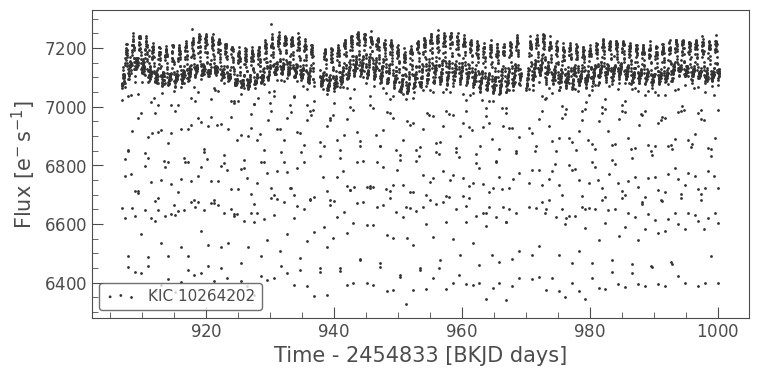

In [3]:

lc.scatter();

This light curve looks like it has some structure in it! Let's use the periodogram class to find the rotation period. You can create a periodogram from the `KeplerLightCurve` object by using the [to_periodogram](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.LightCurve.to_periodogram.html) method.

In [4]:
pg = lc.to_periodogram(oversample_factor=1)

Now we can plot the periodogram in the same way that we plot the original light curve.

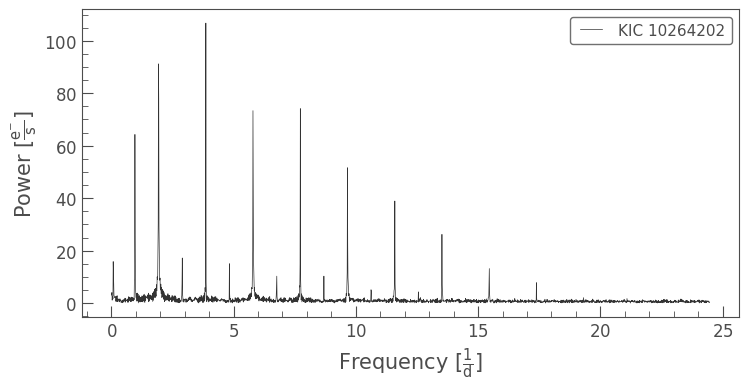

In [5]:
pg.plot();

This looks like there is a huge signal at a certain frequency! Let's plot it in period space, so that we can see what period the oscillation is occurring at.

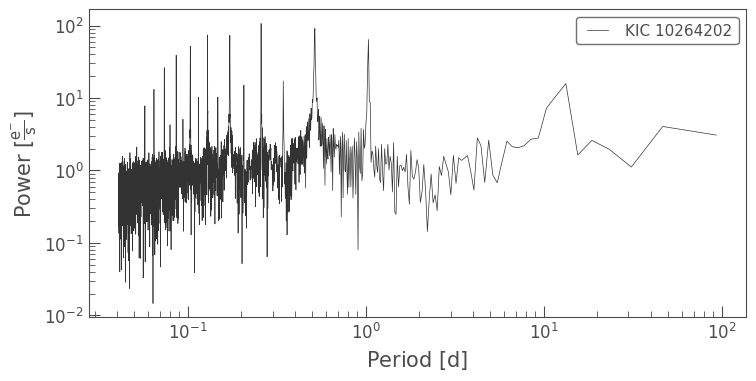

In [6]:
pg.plot(view='period', scale='log');

This looks like a very fast period. We can access the full [period](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.periodogram.Periodogram.period.html) and [power](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.periodogram.Periodogram.power.html) data as follows:

In [7]:
pg.period

<Quantity [9.34019490e+01, 4.67009745e+01, 3.11339830e+01, ...,
           4.09119356e-02, 4.08940232e-02, 4.08761265e-02] d>

In [8]:
pg.power

<Quantity [3.08123354, 4.04909814, 1.11686654, ..., 0.38587579, 0.17211   ,
           0.4266806 ] electron / s>

In this case we simply want to know the period that corresponds to the highest peak in the periodogram.  We can directly access this value using the convenient [period_at_max_power](https://lightkurve.github.io/lightkurve/reference/api/lightkurve.periodogram.Periodogram.period_at_max_power.html) property:

In [9]:
pg.period_at_max_power

<Quantity 0.25873116 d>

We can then use this period to fold our light curve:

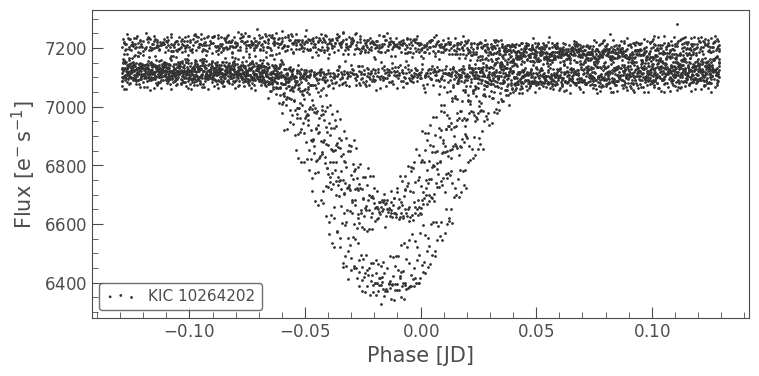

In [10]:
lc.fold(period=pg.period_at_max_power).scatter();

Oops, the eclipses do not line up nicely. This does not look like the correct period of this eclipsing binary!

As is quite common for eclipsing binaries with deep secondary eclipses, we have found a harmonic of the period of the eclipsing binary. Let's plot it again with quadruple the period.

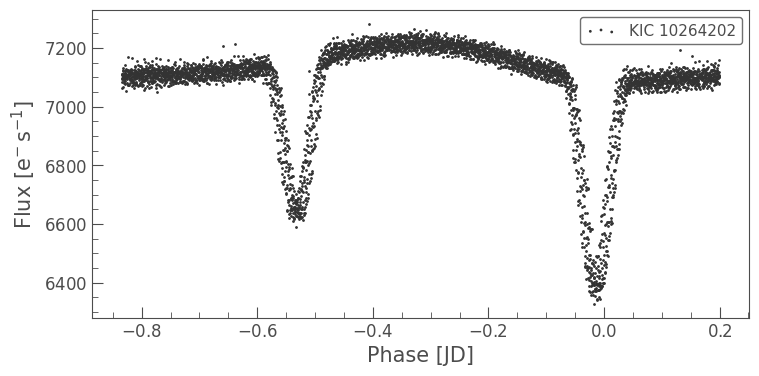

In [11]:
lc.fold(period=4*pg.period_at_max_power, wrap_phase=0.2).scatter();

That looks better, but the eclipses still don't seem to line up as well as they could.

Let's try to get a more precise period by increasing the number of points in our periodogram using the `oversample_factor` parameter and by constraining the range of the period value:

In [12]:
import astropy.units as u
pg = lc.to_periodogram(minimum_period=0.9*u.day, maximum_period=1.2*u.day, oversample_factor=10)
pg.period_at_max_power

<Quantity 1.03509717 d>

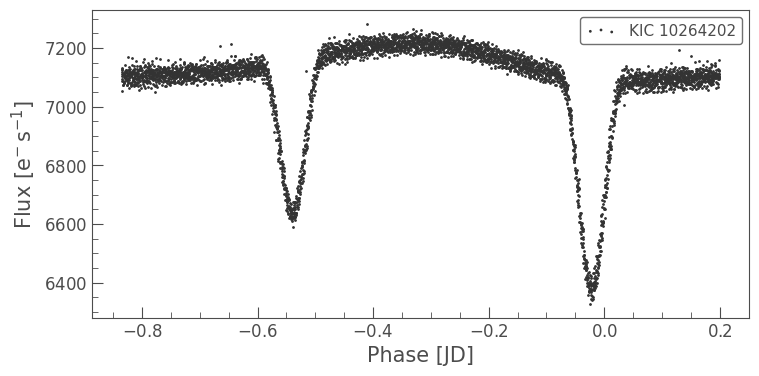

In [13]:
lc.fold(period=pg.period_at_max_power, wrap_phase=0.2).scatter();

This has improved our fit. It looks like this eclipsing binary has a period of approximately 1 day.